## What is RAG?

RAG stands for Retrieval Augmented Generation.

It was first introduced in the paper [*Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks*](https://arxiv.org/abs/2005.11401).

Each step can be roughly broken down to:

* **Retrieval** - Seeking relevant information from a source given a query. For example, getting relevant passages of Wikipedia text from a database given a question.
* **Augmented** - Using the relevant retrieved information to modify an input to a generative model (e.g. an LLM).
* **Generation** - Generating an output given an input. For example, in the case of an LLM, generating a passage of text given an input prompt.

## Why RAG?

The main goal of RAG is to improve the generation outptus of LLMs.

Two primary improvements can be seen as:
1. **Preventing hallucinations** - LLMs are incredible but they are prone to potential hallucination, as in, generating something that *looks* correct but isn't. RAG pipelines can help LLMs generate more factual outputs by providing them with factual (retrieved) inputs. And even if the generated answer from a RAG pipeline doesn't seem correct, because of retrieval, you also have access to the sources where it came from.
2. **Work with custom data** - Many base LLMs are trained with internet-scale text data. This means they have a great ability to model language, however, they often lack specific knowledge. RAG systems can provide LLMs with domain-specific data such as medical information or company documentation and thus customized their outputs to suit specific use cases.

RAG is and easier solution to implement than fine-tuning an LLM on specific data.



## What kind of problems can RAG be used for?

RAG can help anywhere there is a specific set of information that an LLM may not have in its training data (e.g. anything not publicly accessible on the internet).

For example you could use RAG for:
* **Customer support Q&A chat**
* **Email chain analysis**
* **Company internal documentation chat**
* **Textbook Q&A**


## Some Key terms before going into the Legal RAG Project one needs to understand

| Term | Description |
| ----- | ----- |
| **Token** | A sub-word piece of text. For example, "hello, world!" could be split into ["hello", ",", "world", "!"]. A token can be a whole word,<br> part of a word or group of punctuation characters. 1 token ~= 4 characters in English, 100 tokens ~= 75 words.<br> Text gets broken into tokens before being passed to an LLM. |
| **Embedding** | A learned numerical representation of a piece of data. For example, a sentence of text could be represented by a vector with<br> 768 values. Similar pieces of text (in meaning) will ideally have similar values. |
| **Embedding model** | A model designed to accept input data and output a numerical representation. For example, a text embedding model may take in 384 <br>tokens of text and turn it into a vector of size 768. An embedding model can and often is different to an LLM model. |
| **Similarity search/vector search** | Similarity search/vector search aims to find two vectors which are close together in high-demensional space. For example, <br>two pieces of similar text passed through an embedding model should have a high similarity score, whereas two pieces of text about<br> different topics will have a lower similarity score. Common similarity score measures are dot product and cosine similarity. |
| **Large Language Model (LLM)** | A model which has been trained to numerically represent the patterns in text. A generative LLM will continue a sequence when given a sequence. <br>For example, given a sequence of the text "hello, world!", a genertive LLM may produce "we're going to build a RAG pipeline today!".<br> This generation will be highly dependant on the training data and prompt. |
| **LLM context window** | The number of tokens a LLM can accept as input. For example, as of March 2024, GPT-4 has a default context window of 32k tokens<br> (about 96 pages of text) but can go up to 128k if needed. A recent open-source LLM from Google, Gemma (March 2024) has a context<br> window of 8,192 tokens (about 24 pages of text). A higher context window means an LLM can accept more relevant information<br> to assist with a query. For example, in a RAG pipeline, if a model has a larger context window, it can accept more reference items<br> from the retrieval system to aid with its generation. |
| **Prompt** | A common term for describing the input to a generative LLM. The idea of "[prompt engineering](https://en.wikipedia.org/wiki/Prompt_engineering)" is to structure a text-based<br> (or potentially image-based as well) input to a generative LLM in a specific way so that the generated output is ideal. This technique is<br> possible because of a LLMs capacity for in-context learning, as in, it is able to use its representation of language to breakdown <br>the prompt and recognize what a suitable output may be (note: the output of LLMs is probable, so terms like "may output" are used). |




 ## Programming Methodology

We have build a RAG pipeline which enables us to chat with a legal chatbot trainded on Indian legal Acts in the form of PDF documents, which are open-source.

We'll write the code to:
1. Open a PDF documents containing legal content.
2. Preprocess the text of the PDFs for an embedding model.
3. Embed all of the chunks of text in the textbook and turn them into numerical representation (tokens).
4. Build a retrieval system that uses vector search to find relevant chunks of text based on a query.
5. Create a prompt that incorporates the retrieved pieces of text(prompt engineering).
6. Generate an answer to a query based on legal text provided.

The above steps can broken down into two major sections:
1. Document preprocessing/embedding creation (steps 1-3).
2. Search and answer (steps 4-6).


It's similar to the workflow outlined on the NVIDIA blog which [details a local RAG pipeline](https://developer.nvidia.com/blog/rag-101-demystifying-retrieval-augmented-generation-pipelines/).

<img src="https://github.com/mrdbourke/simple-local-rag/blob/main/images/simple-local-rag-workflow-flowchart.png?raw=true" alt="flowchart of a local RAG workflow" />

Image Copyright: Nvidia

## Requirements and setup

* Google Colab with access to a T4 GPU (which was freely available but with limited runtime).
* Environment setup (necessary frameworks, libraries and additional modules to test and evaluate responses/outputs).
* Data source - Indian Legal Acts(revised and updated 2024).
* Internet connection .

In [1]:
# Perform Google Colab installs (if running in Google Colab)
import os

if "COLAB_GPU" in os.environ:
    print("[INFO] Running in Google Colab, installing requirements.")
    !pip install -U torch # requires torch 2.1.1+ (for efficient sdpa implementation)
    !pip install PyMuPDF # for reading PDFs with Python
    !pip install tqdm # for progress bars
    !pip install sentence-transformers # for embedding models
    !pip install accelerate # for quantization model loading
    !pip install bitsandbytes # for quantizing models (less storage space)
    !pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference

[INFO] Running in Google Colab, installing requirements.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 4.6 MB/s eta 0:00

## 1. Document/Text Processing and Embedding Creation

Steps:
1. Import PDF document.
2. Process text for embedding (e.g. split into chunks of sentences).
3. Embed text chunks with embedding model.
4. Save embeddings to file for later use (embeddings will store on file for many years or until you lose your hard drive).

### Import PDF Document

In [38]:
import os
import requests

pdf_path = "/content/drive/MyDrive/model/Constitution of India, 1950.pdf"

# We can also download PDFs from cloud or github, if it doesn't already exist but we need to provide the link
if not os.path.exists(pdf_path):
  print("File doesn't exist, downloading...")

  # The URL of the PDF
  url = "https://github.com/ManishBangari/Legal_Chatbot/blob/main/Data%20_Acts/Constitution%20of%20India%2C%201950.pdf"

  # The local filename to save the downloaded file in colab
  filename = pdf_path

  # Send a GET request to the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      with open(filename, "wb") as file:
          file.write(response.content)
      print(f"The file has been downloaded and saved as {filename}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print(f"File {pdf_path} exists.")

File /content/drive/MyDrive/model/Constitution of India, 1950.pdf exists.


### Get metadata of the PDFs

In [39]:
# Requires !pip install PyMuPDF
import fitz
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip()

    # Other potential text formatting functions can go here
    return cleaned_text

# Open PDF and get lines/pages
# Note: this only focuses on text, rather than images/figures etc
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str): The file path to the PDF document to be opened and read.

    Returns:
        list[dict]: A list of dictionaries, each containing the page number
        (adjusted), character count, word count, sentence count, token count, and the extracted text
        for each page.
    """
    doc = fitz.open(pdf_path)  # open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):  # iterate the document pages
        text = page.get_text()  # get plain text encoded as UTF-8
        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number - 41,  # adjust page numbers since our PDF starts on page 42
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars, see: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 56,
  'page_word_count': 17,
  'page_sentence_count_raw': 1,
  'page_token_count': 14.0,
  'text': 'THE CONSTITUTION OF INDIA  [As on       May, 2022]  2022'},
 {'page_number': -40,
  'page_char_count': 972,
  'page_word_count': 239,
  'page_sentence_count_raw': 7,
  'page_token_count': 243.0,
  'text': 'PREFACE    This is the  fifth  pocket size edition of the Constitution of  India in the diglot form. In this edition, the text of the  Constitution of India has been brought up-to-date by  incorporating therein all the amendments up to the Constitution  (One Hundred and Fifth Amendment) Act, 2021. The foot notes  below the text indicate the Constitution Amendment Acts by  which such amendments have been made.   The Constitution (One Hundredth Amendment) Act, 2015  containing details of acquired and transferred territories  between the Governments of India and Bangladesh has been  provided in APPENDIX I.  The Constitution (Application to Jammu 

Now let's get a random sample of the pages.

In [40]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': 331,
  'page_char_count': 1758,
  'page_word_count': 320,
  'page_sentence_count_raw': 32,
  'page_token_count': 439.5,
  'text': 'THE CONSTITUTION OF  INDIA  (Ninth Schedule)  341 230. The Madhya Pradesh Ceiling on Agricultural Holdings (Amendment)  Act, 1989 (Madhya Pradesh Act 8 of 1989).  231. The Maharashtra Land Revenue Code, 1966 (Maharashtra Act 41 of  1966), sections 36, 36A and 36B.  232. The  Maharashtra  Land  Revenue  Code  and  the Maharashtra  Restoration of Lands to Scheduled Tribes (Second Amendment) Act, 1976  (Maharashtra Act 30 of 1977).  233. The Maharashtra Abolition of Subsisting Proprietary Rights to Mines  and Minerals in certain Lands Act, 1985 (Maharashtra Act 16 of 1985).  234. The Orissa Scheduled Areas Transfer of Immovable Property (by  Scheduled Tribes) Regulation, 1956 (Orissa Regulation 2 of 1956).  235. The Orissa Land Reforms (Second Amendment) Act, 1975 (Orissa  Act 29 of 1976).  236. The Orissa Land Reforms (Amendment) Act, 1976 (O

### Exploratory Data Analysis

A rough exploratory data analysis (EDA) to get an idea of the size of the texts (e.g. character counts, word counts etc) we're working with and it will give good indicator into how we should split our texts.


We have turn our list of dictionaries into a DataFrame using pandas library.

In [41]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,56,17,1,14.00,"THE CONSTITUTION OF INDIA [As on May, 2..."
1,-40,972,239,7,243.00,PREFACE This is the fifth pocket size edi...
2,-39,1166,222,36,291.50,"LIST OF ABBREVIATIONS USED Art., arts. ...."
3,-38,1249,412,23,312.25,THE CONSTITUTION OF INDIA ____________ ...
4,-37,1232,241,36,308.00,Contents ARTICLES (ii) PART III FUNDAM...


In [42]:
# Get stats
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,404.00,404.00,404.00,404.00,404.00
mean,160.50,2169.82,407.55,20.35,542.46
std,116.77,540.83,100.20,13.12,135.21
min,-41.00,55.00,10.00,1.00,13.75
25%,59.75,1900.75,352.50,9.00,475.19
50%,160.50,2263.00,418.00,18.00,565.75
75%,261.25,2543.25,478.00,30.00,635.81
max,362.00,3981.00,775.00,91.00,995.25


Okay, looks like our average token count per page is 565.

we have embed an average whole page with the `all-mpnet-base-v2` model (this model has an input capacity of 768).

### Further text processing (splitting pages into sentences)

The ideal way of processing text before embedding it is still an active area of research.

Workflow :

`Ingest text -> split it into groups/chunks -> embed the groups/chunks -> use the embeddings`

1. Split into sentences with simple rules (e.g. split on ". " with `text = text.split(". ")`).
2. Split into sentences with NLP library such as [spaCy](https://spacy.io/) or [nltk](https://www.nltk.org/).

Why split is important?

* Easier to handle than larger pages of text (especially if pages are densely filled with text).
* Can get specific and find out which group of sentences were used to help within a RAG pipeline.

In [43]:
from spacy.lang.en import English

nlp = English()

# Add a sentencizer pipeline
nlp.add_pipe("sentencizer")

# for experimentation purpose
doc = nlp("This is first sentence. This is second sentence.")
assert len(list(doc.sents)) == 2

list(doc.sents)

[This is first sentence., This is second sentence.]

In [44]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # Make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # Count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/404 [00:00<?, ?it/s]

In [45]:
random.sample(pages_and_texts, k=1)

[{'page_number': 269,
  'page_char_count': 1463,
  'page_word_count': 276,
  'page_sentence_count_raw': 9,
  'page_token_count': 365.75,
  'text': 'THE CONSTITUTION OF  INDIA  (Fifth Schedule)  279 (c) on any alteration of the boundaries of a State or on the  admission into the Union or the establishment of a new State, declare  any territory not previously included in any State to be, or to form part  of, a Scheduled Area;  1[(d) rescind, in relation to any State or States, any order or orders  made under this paragraph, and in consultation with the Governor of the  State concerned, make fresh orders redefining the areas which are to be  Scheduled Areas;]  and any such order may contain such incidental and consequential provisions as  appear to the President to be necessary and proper, but save as aforesaid, the  order made under sub-paragraph (1) of this paragraph shall not be varied by  any subsequent order.  PART D  AMENDMENT OF THE SCHEDULE  7. Amendment of the Schedule.—(1) Parli

Now turn out list of dictionaries into a DataFrame and do some analysis.

In [46]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,404.00,404.00,404.00,404.00,404.00,404.00
mean,160.50,2169.82,407.55,20.35,542.46,18.85
std,116.77,540.83,100.20,13.12,135.21,12.10
min,-41.00,55.00,10.00,1.00,13.75,1.00
25%,59.75,1900.75,352.50,9.00,475.19,8.00
50%,160.50,2263.00,418.00,18.00,565.75,16.00
75%,261.25,2543.25,478.00,30.00,635.81,28.00
max,362.00,3981.00,775.00,91.00,995.25,76.00


### Chunking our sentences together

Now, we will break down our list of sentences/text into smaller chunks also referred to as **chunking**.

On average each of our pages has 10 sentences.

And an average total of 287 tokens per page.

So our groups of 10 sentences will also be ~287 tokens long.

This gives us plenty of room for the text to embedded by our `all-mpnet-base-v2` model (it has a capacity of 768 tokens).

In [47]:
# Define split size
num_sentence_chunk_size = 10

# A function that recursively splits a list into desired sizes
def split_list(input_list: list,
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 17 sentences would be split into two lists of [[10], [7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/404 [00:00<?, ?it/s]

In [48]:
# Sample an example from the group
random.sample(pages_and_texts, k=1)

[{'page_number': 30,
  'page_char_count': 2570,
  'page_word_count': 489,
  'page_sentence_count_raw': 10,
  'page_token_count': 642.5,
  'text': 'THE CONSTITUTION OF  INDIA  (Part V.—The Union)  41 Officers of Parliament  89. The Chairman and Deputy Chairman of the Council of States.—(1)  The Vice- President of India shall be ex officio Chairman of the Council of States.  (2) The Council of States shall, as soon as may be, choose a member of  the Council to be Deputy Chairman thereof and, so often as the office of  Deputy Chairman becomes vacant, the Council shall choose another member to  be Deputy Chairman thereof.  90. Vacation and resignation of, and removal from, the office of  Deputy Chairman.—A member holding office as Deputy Chairman of the  Council of States—  (a)  shall vacate his office if he ceases to be a member of the Council;  (b) may at any time, by writing under his hand addressed to the  Chairman, resign his office; and  (c) may be removed from his office by a resolu

In [49]:
# Create a DataFrame to get some stats
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,404.00,404.00,404.00,404.00,404.00,404.00,404.00
mean,160.50,2169.82,407.55,20.35,542.46,18.85,2.32
std,116.77,540.83,100.20,13.12,135.21,12.10,1.24
min,-41.00,55.00,10.00,1.00,13.75,1.00,1.00
25%,59.75,1900.75,352.50,9.00,475.19,8.00,1.00
50%,160.50,2263.00,418.00,18.00,565.75,16.00,2.00
75%,261.25,2543.25,478.00,30.00,635.81,28.00,3.00
max,362.00,3981.00,775.00,91.00,995.25,76.00,8.00


Note how the average number of chunks is around 2, this is expected since many of our pages only contain an average of 15 sentences.

### Splitting each chunk into its own item
A new list of dictionaries each containing a single chunk of sentences with relative information such as page number as well statistics about each chunk.

In [50]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters

        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

  0%|          | 0/404 [00:00<?, ?it/s]

936

In [51]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 304,
  'sentence_chunk': 'THE CONSTITUTION OF INDIA (Seventh Schedule)  314 64. Institutions for scientific or technical education financed by the Government of India wholly or in part and declared by Parliament by law to be institutions of national importance. 65. Union agencies and institutions for— (a) professional, vocational or technical training, including the training of police officers; or (b) the promotion of special studies or research; or (c) scientific or technical assistance in the investigation or detection of crime. 66. Co-ordination and determination of standards in institutions for higher education or research and scientific and technical institutions. 67. Ancient and historical monuments and records, and archaeological sites and remains, 1[declared by or under law made by Parliament] to be of national importance. 68. The Survey of India, the Geological, Botanical, Zoological and Anthropological Surveys of India; Meteorological organisations.',
  'chun

Some stats about our chunks.

In [52]:
# Get stats about our chunks
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,936.00,936.00,936.00,936.00
mean,161.85,911.41,151.34,227.85
std,125.19,866.94,148.18,216.73
min,-41.00,10.00,1.00,2.50
25%,47.75,233.75,35.75,58.44
50%,167.50,453.50,73.00,113.38
75%,278.25,1805.00,303.25,451.25
max,362.00,3851.00,645.00,962.75


In [53]:
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 2.75 | Text: 21-1-1972).
Chunk token count: 25.75 | Text: w.e.f.2-4-1970).   2. Subs.by s. 74 and Fourth Sch.,ibid.for "paragraph 6" (w.e.f.2-4-1970).   3. Subs.
Chunk token count: 26.75 | Text: This amendment was omitted by the Constitution (Forty-fourth Amendment) Act, 1978, s. 45 (w.e.f.20-6-1979).
Chunk token count: 21.0 | Text: The President of India. 53. Executive power of the Union. 54. Election of President.
Chunk token count: 23.0 | Text: by the Constitution (Twenty-sixth Amendment) Act, 1971, s. 3             (w.e.f.28-12-1971).


In [54]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -40,
  'sentence_chunk': 'PREFACE  This is the fifth pocket size edition of the Constitution of India in the diglot form. In this edition, the text of the Constitution of India has been brought up-to-date by incorporating therein all the amendments up to the Constitution (One Hundred and Fifth Amendment) Act, 2021. The foot notes below the text indicate the Constitution Amendment Acts by which such amendments have been made. The Constitution (One Hundredth Amendment) Act, 2015 containing details of acquired and transferred territories between the Governments of India and Bangladesh has been provided in APPENDIX I. The Constitution (Application to Jammu and Kashmir) Order, 2019 and the declaration under article 370(3) of the Constitution have been provided respectively in Appendix II and Appendix III for reference.   New Delhi;                        Dr. Reeta Vasishta,                  Secretary to the Government of India.',
  'chunk_char_count': 910,
  'chunk_word_cou

Smaller chunks filtered!

Time to embed our chunks of text!

### Embedding our text chunks

> **Note:** Most modern NLP models deal with "tokens" which can be considered as multiple different sizes and combinations of words and characters rather than always whole words or single characters. For example, the string `"hello world!"` gets mapped to the token values `{15339: b'hello', 1917: b' world', 0: b'!'}` using [Byte pair encoding](https://en.wikipedia.org/wiki/Byte_pair_encoding) (or BPE via OpenAI's [`tiktoken`](https://github.com/openai/tiktoken) library). Google has a tokenization library called [SentencePiece](https://github.com/google/sentencepiece).

Our goal is to turn each of our chunks into a numerical representation (an embedding vector, where a vector is a sequence of numbers arranged in order).

To do so, we'll use the [`sentence-transformers`](https://www.sbert.net/docs/installation.html) library which contains many pre-trained embedding models.

Specifically, we'll get the `all-mpnet-base-v2` model (you can see the model's intended use on the [Hugging Face model card](https://huggingface.co/sentence-transformers/all-mpnet-base-v2#intended-uses)).

In [32]:
# Requires !pip install sentence-transformers
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device="cuda") # choose the device to load the model to (note: GPU will often be *much* faster than CPU)

# Create a list of sentences to turn into numbers
sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence: The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embedding: [-2.07981113e-02  3.03164795e-02 -2.01218147e-02  6.86483756e-02
 -2.55255271e-02 -8.47689621e-03 -2.07084100e-04 -6.32377341e-02
  2.81606186e-02 -3.33352946e-02  3.02635301e-02  5.30720539e-02
 -5.03526032e-02  2.62288153e-02  3.33314314e-02 -4.51578870e-02
  3.63044329e-02 -1.37113058e-03 -1.20171346e-02  1.14946300e-02
  5.04510924e-02  4.70857024e-02  2.11912952e-02  5.14607318e-02
 -2.03746632e-02 -3.58889513e-02 -6.67892222e-04 -2.94393133e-02
  4.95858938e-02 -1.05639584e-02 -1.52014289e-02 -1.31752621e-03
  4.48197350e-02  1.56022953e-02  8.60380283e-07 -1.21392391e-03
 -2.37978548e-02 -9.09427938e-04  7.34480796e-03 -2.53931968e-03
  5.23369759e-02 -4.68043573e-02  1.66214537e-02  4.71578874e-02
 -4.15599234e-02  9.01929627e-04  3.60278897e-02  3.42214443e-02
  9.68227461e-02  5.94828576e-02 -1.64984558e-02 -3.51249650e-02
  5.92514267e-03 -7.08006672e-04 -2.4103



Checking for just once sentence

In [33]:
single_sentence = "This is our final year project."
single_embedding = embedding_model.encode(single_sentence)
print(f"Sentence: {single_sentence}")
print(f"Embedding:\n{single_embedding}")
print(f"Embedding size: {single_embedding.shape}")

Sentence: This is our final year project.
Embedding:
[ 2.11925004e-02  4.78637815e-02 -3.42409238e-02  1.76027529e-02
 -3.25040482e-02 -4.69662771e-02 -2.31107362e-02 -2.64813304e-02
 -1.30843734e-02  2.01427266e-02  9.63444337e-02 -6.91566104e-03
 -1.49861735e-03  1.99789573e-02 -9.88484733e-03 -1.04076229e-01
  1.04467655e-02 -7.79796951e-03 -8.51021484e-02 -2.63975076e-02
 -5.23383021e-02  1.11162933e-02  3.70332859e-02 -2.29889136e-02
 -3.00920438e-02  2.82466179e-03 -1.06952041e-01  3.91586171e-03
 -2.02781614e-03 -3.10273003e-02  4.73591611e-02 -1.05692782e-02
 -9.12634376e-03 -8.64474848e-03  1.52623625e-06 -1.25955162e-03
  2.57094409e-02  4.02613217e-03 -1.68196540e-02  3.36104408e-02
  8.02300349e-02 -3.05686379e-04 -1.74284037e-02  1.05828755e-02
  4.39742161e-03 -6.30180612e-02  7.60618523e-02  5.12972381e-03
  1.07951462e-02 -4.14091796e-02  1.69660505e-02 -6.88043460e-02
  1.65031888e-02 -1.18498420e-02 -1.95625285e-03 -1.34246089e-02
 -1.20353363e-02  6.18812814e-03  3.2

Our embedding has a shape of `(768,)` meaning it's a vector of 768 numbers which represent our text in high-dimensional space, too many for a human to comprehend but machines love high-dimensional space.


How long it takes to create the embeddings with a GPU??.

Experiment part

In [55]:
%%time
from tqdm.auto import tqdm

# Send the model to the GPU
embedding_model.to("cuda") # COlab T4 GPU

# Create embeddings
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/826 [00:00<?, ?it/s]

CPU times: user 18.7 s, sys: 1.48 ms, total: 18.7 s
Wall time: 19.3 s


~10x faster on the T4 GPU machine.

We will perform batched operations by turning our target text samples into a single list and then passing that list to our embedding model.

In [56]:
# Turn text chunks into a single list
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

In [57]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,batch_size=32, # We found 32 works well for this use case
                                               convert_to_tensor=True)

text_chunk_embeddings

CPU times: user 11.9 s, sys: 0 ns, total: 11.9 s
Wall time: 14 s


tensor([[ 0.0187, -0.0326, -0.0202,  ..., -0.0107, -0.0508,  0.0126],
        [ 0.0204, -0.0851, -0.0089,  ..., -0.0466, -0.0425, -0.0091],
        [-0.0470,  0.0367, -0.0023,  ..., -0.0218, -0.0387, -0.0035],
        ...,
        [ 0.0092,  0.0050, -0.0112,  ...,  0.0329, -0.0266,  0.0177],
        [ 0.0235, -0.0230,  0.0030,  ..., -0.0414, -0.0585,  0.0141],
        [ 0.0131, -0.0616,  0.0006,  ..., -0.0228, -0.0499,  0.0101]],
       device='cuda:0')

In [86]:
torch.save(embedding_model.state_dict(), '/content/drive/MyDrive/model/embedding_model.pth')

In [58]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "/content/drive/MyDrive/model/text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [59]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-40,PREFACE This is the fifth pocket size edition...,910,177,227.50,[ 1.87183544e-02 -3.25894803e-02 -2.01721806e-...
1,-39,"LIST OF ABBREVIATIONS USED Art.,arts. .........",387,44,96.75,[ 2.04361510e-02 -8.50692987e-02 -8.88909493e-...
2,-39,.................................................,407,46,101.75,[-4.69693653e-02 3.66550945e-02 -2.33818823e-...
3,-39,.................................................,264,26,66.00,[ 7.26438547e-03 -4.59968410e-02 9.69820842e-...
4,-38,THE CONSTITUTION OF INDIA ____________ ...,627,189,156.75,[ 5.49932523e-03 1.53377391e-02 4.29773750e-...


## 2. RAG - Search and Answer

RAG stands for Retrieval Augmented Generation.

Briefly, "given a query, search for relevant resources and answer based on those resources".

* **Retrieval** - Get relevant resources given a query. For example, if the query is "what are the macronutrients?" the ideal results will contain information about protein, carbohydrates and fats (and possibly alcohol) rather than information about which tractors are the best for farming (though that is also cool information).
* **Augmentation** - LLMs are capable of generating text given a prompt. However, this generated text is designed to *look* right. And it often has some correct information, however, they are prone to hallucination (generating a result that *looks* like legit text but is factually wrong). In augmentation, we pass relevant information into the prompt and get an LLM to use that relevant information as the basis of its generation.
* **Generation** - This is where the LLM will generate a response that has been flavoured/augmented with the retrieved resources. In turn, this not only gives us a potentially more correct answer, it also gives us resources to investigate more (since we know which resources went into the prompt).

The whole idea of RAG is to get an LLM to be more factually correct based on your own input as well as have a reference to where the generated output may have come from.

### Analogy with Similarity search


In [61]:
import random

import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("/content/drive/MyDrive/model/text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([826, 768])

In [62]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-40,PREFACE This is the fifth pocket size edition...,910,177,227.50,"[0.0187183544, -0.0325894803, -0.0201721806, -..."
1,-39,"LIST OF ABBREVIATIONS USED Art.,arts. .........",387,44,96.75,"[0.020436151, -0.0850692987, -0.00888909493, 0..."
2,-39,.................................................,407,46,101.75,"[-0.0469693653, 0.0366550945, -0.00233818823, ..."
3,-39,.................................................,264,26,66.00,"[0.00726438547, -0.045996841, 0.00969820842, -..."
4,-38,THE CONSTITUTION OF INDIA ____________ ...,627,189,156.75,"[0.00549932523, 0.0153377391, 0.0042977375, -0..."


In [63]:
embeddings[0]

tensor([ 1.8718e-02, -3.2589e-02, -2.0172e-02, -2.5212e-02, -6.7339e-02,
         5.0885e-03, -1.5589e-02, -4.9223e-03,  6.6630e-03,  1.2665e-02,
         4.8654e-02,  4.5274e-03,  2.9046e-02,  3.0788e-02,  2.2159e-02,
        -4.2359e-02, -1.1234e-02, -1.0937e-02, -4.0869e-02,  3.2452e-02,
        -4.1511e-02, -5.1799e-03, -1.6952e-02,  2.2265e-02,  1.1365e-02,
         7.4148e-03,  2.2481e-02,  9.0267e-03, -8.2828e-02, -2.3300e-02,
         2.7024e-02,  2.2965e-03,  6.7481e-02, -8.3924e-02,  2.3682e-06,
        -4.9592e-02,  6.4323e-03,  4.0827e-02, -2.0925e-02,  3.0110e-02,
         4.6531e-04, -6.4735e-04,  5.3736e-03,  1.2138e-02, -1.4259e-02,
         2.5219e-02, -1.3129e-02,  1.0452e-01,  3.7393e-02,  8.9909e-02,
         2.7465e-02, -2.2782e-02, -4.6523e-02, -7.3029e-03,  2.5769e-02,
        -1.8536e-03, -1.7187e-02, -1.9304e-02,  4.1582e-02,  3.5971e-02,
        -8.8347e-04, -6.1891e-03,  7.2757e-03, -5.2200e-02,  1.2350e-02,
        -3.6336e-02,  3.4439e-02, -8.2943e-03,  9.9

In [64]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device) # choose the device eg cpu or cuda

Embedding model is finally ready.

Time to perform the semantic search.

Steps followed:
1. Define the query string (e.g. `"fundamental rights"`).
2. Turn the query string in an embedding with same model used to embed the text chunks.
3. Perform a [dot product](https://pytorch.org/docs/stable/generated/torch.dot.html) or [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) function between the text embeddings and the query embedding to get similarity scores.
4. Sort the results from step 3 in descending order (a higher score means more similarity in the eyes of the model) and use these values to inspect the texts.


In [65]:
# 1. Define the query

query = "What are FUNDAMENTAL RIGHTS?"
print(f"Query: {query}")

# 2. Embedding the query.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Getting similarity scores with the dot product
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top results
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: What are FUNDAMENTAL RIGHTS?
Time take to get scores on 826 embeddings: 0.00065 seconds.


torch.return_types.topk(
values=tensor([0.7129, 0.6259, 0.5612, 0.5439, 0.5109], device='cuda:0'),
indices=tensor([  6,   8,   7,   9, 113], device='cuda:0'))

In [66]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product across 168,000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([82600, 768])
Time take to get scores on 82600 embeddings: 0.01891 seconds.



For *much* larger datasets, one can use a dedicated vector database/indexing libraries such as [Faiss](https://github.com/facebookresearch/faiss).


[`torch.topk`](https://pytorch.org/docs/stable/generated/torch.topk.html) returns a tuple of values (scores) and indicies for those scores.

The indicies relate to which indicies in the `embeddings` tensor have what scores in relation to the query embedding (higher is better).

I have used those indicies to map back to our text chunks.

In [67]:
# helper function to print wrapped text
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

Now we can loop through the `top_results_dot_product` tuple and match up the scores and indicies and then use those indicies to index on our `pages_and_chunks` variable to get the relevant text chunk.

In [68]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'What are FUNDAMENTAL RIGHTS?'

Results:
Score: 0.7129
Text:
Contents    ARTICLES (ii) PART III FUNDAMENTAL RIGHTS General 12. Definition.
13. Laws inconsistent with or in derogation of the fundamental rights.  Right to
Equality 14.  Equality before law. 15. Prohibition of discrimination on grounds
of religion, race, caste, sex or place of birth. 16. Equality of opportunity in
matters of public employment.
Page number: -37


Score: 0.6259
Text:
21A. Right to education. 22. Protection against arrest and detention in certain
cases.  Right against Exploitation 23. Prohibition of traffic in human beings
and forced labour. 24. Prohibition of employment of children in factories, etc.
Right to Freedom of Religion 25. Freedom of conscience and free profession,
practice and propagation of religion. 26.
Page number: -37


Score: 0.5612
Text:
17. Abolition of Untouchability. 18. Abolition of titles.  Right to Freedom 19.
Protection of certain rights regarding freedom of speech, etc. 20. Pr

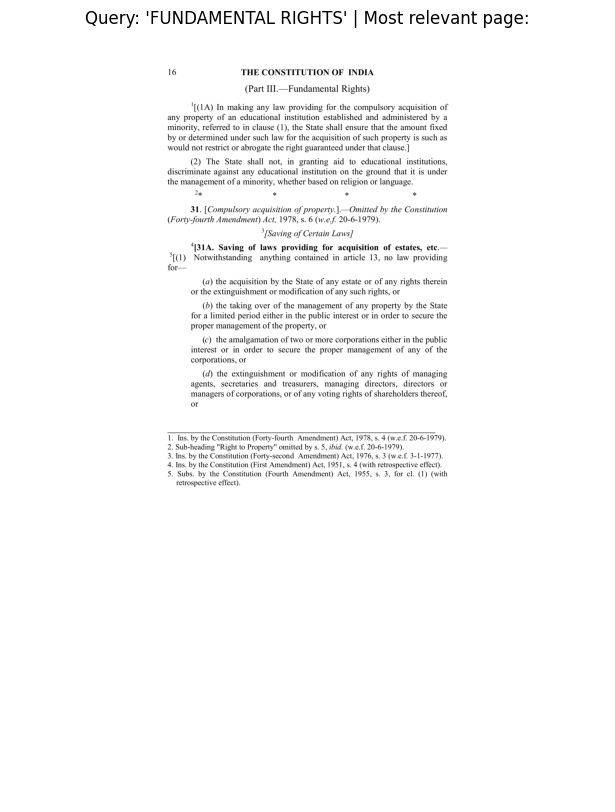

In [ ]:
import fitz

# Open PDF and load target page
pdf_path = "/content/data/Constitution of India, 1950.pdf" # it requires PDF to be downloaded
doc = fitz.open(pdf_path)
page = doc.load_page(5 + 41) # number of page

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image for analysis purpose in legal context
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off')
plt.show()

### Similarity measures: dot product and cosine similarity

Let's talk similarity measures between vectors.

Specifically, embedding vectors which are representations of data with magnitude and direction in high dimensional space (our embedding vectors have 768 dimensions).

The main difference is that cosine similarity has a normalization step.

| Similarity measure | Description | Code |
| ----- | ----- | ----- |
| [Dot Product](https://en.wikipedia.org/wiki/Dot_product) | - Measure of magnitude and direction between two vectors<br>- Vectors that are aligned in direction and magnitude have a higher positive value<br>- Vectors that are opposite in direction and magnitude have a higher negative value | [`torch.dot`](https://pytorch.org/docs/stable/generated/torch.dot.html), [`np.dot`](https://numpy.org/doc/stable/reference/generated/numpy.dot.html), [`sentence_transformers.util.dot_score`](https://www.sbert.net/docs/package_reference/util.html#sentence_transformers.util.dot_score) |
| [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) | - Vectors get normalized by magnitude/[Euclidean norm](https://en.wikipedia.org/wiki/Norm_(mathematics))/L2 norm so they have unit length and are compared more so on direction<br>- Vectors that are aligned in direction have a value close to 1<br>- Vectors that are opposite in direction have a value close to -1 | [`torch.nn.functional.cosine_similarity`](https://pytorch.org/docs/stable/generated/torch.nn.functional.cosine_similarity.html), [`1 - scipy.spatial.distance.cosine`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html) (subtract the distance from 1 for similarity measure), [`sentence_transformers.util.cos_sim`](https://www.sbert.net/docs/package_reference/util.html#sentence_transformers.util.cos_sim) |


Our embedding model `all-mpnet-base-v2` outputs normalized outputs ([Hugging Face model card](https://huggingface.co/sentence-transformers/all-mpnet-base-v2#usage-huggingface-transformers)) so dot product and cosine similarity return the same results. However, dot product is faster due to not need to perform a normalize step.


In [ ]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L2 norm of each vector (removes the magnitude, keeps direction)
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

# Example tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# Calculate cosine similarity
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


Both dot product and cosine similarity the comparisons of `vector1` and `vector2` are the opposite of `vector1` and `vector4`.

Comparing `vector1` and `vector2` both equations return positive values (14 for dot product and 1.0 for cosine similarity).

But comparing `vector1` and `vector4` the result is in the negative direction, as `vector4` is the negative version of `vector1`.

Whereas comparing `vector1` and `vector3` shows a different outcome.

For the dot product, the value is positive and larger then the comparison of two exactly the same vectors (32 vs 14).

However, for the cosine similarity, thanks to the normalization step, comparing `vector1` and `vector3` results in a postive value close to 1 but not exactly 1.

It is due to the fact that when comparing text embeddings, cosine similarity is generally favoured as it measures the difference in direction of a pair of vectors rather than difference in magnitude.

### Functionizing our semantic search pipeline


In [69]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query,
                                   convert_to_tensor=True)

    # Gets dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """

    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)

    print(f"Query: {query}\n")
    print("Results:")
    # To Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [70]:
query = "what are FUNDAMENTAL DUTIES?"

# scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 826 embeddings: 0.00006 seconds.


(tensor([0.5911, 0.5626, 0.5054, 0.4997, 0.4644], device='cuda:0'),
 tensor([151,  15,  14, 791,   6], device='cuda:0'))

In [71]:
# texts of the top scores
print_top_results_and_scores(query=query,embeddings=embeddings)

[INFO] Time taken to get scores on 826 embeddings: 0.00010 seconds.
Query: what are FUNDAMENTAL DUTIES?

Results:
Score: 0.5911
25 1[PART IVA  FUNDAMENTAL DUTIES 51A. Fundamental duties.—It shall be the duty
of every citizen of India— (a) to abide by the Constitution and respect its
ideals and institutions, the National Flag and the National Anthem; (b) to
cherish and follow the noble ideals which inspired our national struggle for
freedom; (c) to uphold and protect the sovereignty, unity and integrity of
India; (d) to defend the country and render national service when called upon to
do so; (e) to promote harmony and the spirit of common brotherhood amongst all
the people of India transcending religious, linguistic and regional or sectional
diversities; to renounce practices derogatory to the dignity of women; (f) to
value and preserve the rich heritage of our composite culture; (g) to protect
and improve the natural environment including forests, lakes, rivers and wild
life, and to h

### Getting an LLM for final response generation

We're got our retrieval pipeline ready, let's now get the generation side of things happening.

To perform generation, we have used a Large Language Model (LLM).

LLMs are designed to generate an output given an input.

In our case, we want our LLM to generate and output of text given a input of text.

And more specifically, we want the output of text to be generated based on the context of relevant information to the query.

The input to an LLM is often referred to as a prompt.

We'll augment our prompt with a query as well as context from our PDF related to that query.


The following table gives an insight into how much GPU memory you'll need to load an LLM with different sizes and different levels of [numerical precision](https://en.wikipedia.org/wiki/Precision_(computer_science)).

They are based on the fact that 1 float32 value (e.g. `0.69420`) requires 4 bytes of memory and 1GB is approximately 1,000,000,000 (one billion) bytes.

| Model Size (Billion Parameters) | Float32 VRAM (GB) | Float16 VRAM (GB) | 8-bit VRAM (GB) | 4-bit VRAM (GB) |
|-----|-----|-----|-----|-----|
| 1B                              | ~4                | ~2                | ~1              | ~0.5            |
| 7B (e.g., [Llama 2 7B](https://huggingface.co/meta-llama/Llama-2-7b), [Gemma 7B](https://huggingface.co/google/gemma-7b-it), [Mistral 7B](https://huggingface.co/mistralai/Mistral-7B-v0.1))             | ~28               | ~14               | ~7              | ~3.5            |
| 10B                             | ~40               | ~20               | ~10             | ~5              |
| 70B (e.g, Llama 2 70B)          | ~280              | ~140              | ~70             | ~35             |
| 100B                            | ~400              | ~200              | ~100            | ~50             |
| 175B                            | ~700              | ~350              | ~175            | ~87.5           |

<br>

> **Note:** Loading a model in a lower precision (e.g. 8-bit instead of float16) generally lowers performance. Lower precision can help to reduce computing requirements, however sometimes the performance degradation in terms of model output can be substantial. Finding the right speed/performance tradeoff will often require many experiments.

### Checking GPU memory availability in Colab


In [72]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 15 GB


We have used the recently released (on March 2024) LLM from Google, [Gemma](https://huggingface.co/blog/gemma).

Specifically, we have used the `gemma-2b-it` version which stands for Gemma 2B Instruction-Tuned.

Instruction tuning is the process of tuning a raw language model to follow instructions.

The following table shows different amounts of GPU memory requirements for different versions of the Gemma LLMs with varying levels of precision.

| Model             | Precision | Min-Memory (Bytes) | Min-Memory (MB) | Min-Memory (GB) | Recommended Memory (GB) | Hugging Face ID |
|-------------------|-----------|----------------|-------------|-------------| ----- | ----- |
| [Gemma 2B](https://huggingface.co/google/gemma-2b-it)          | 4-bit     | 2,106,749,952  | 2009.15     | 1.96        | ~5.0 | [`gemma-2b`](https://huggingface.co/google/gemma-2b) or [`gemma-2b-it`](https://huggingface.co/google/gemma-2b-it) for instruction tuned version |
| Gemma 2B          | Float16   | 5,079,453,696  | 4844.14     | 4.73        | ~8.0 | Same as above |
| [Gemma 7B](https://huggingface.co/google/gemma-7b-it)          | 4-bit     | 5,515,859,968  | 5260.33     | 5.14        | ~8.0 | [`gemma-7b`](https://huggingface.co/google/gemma-7b) or [`gemma-7b-it`](https://huggingface.co/google/gemma-7b-it) for instruction tuned version |
| Gemma 7B          | Float16   | 17,142,470,656 | 16348.33    | 15.97       | ~19 | Same as above |


In [11]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 15 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.
use_quantization_config set to: False
model_id set to: google/gemma-2b-it


In [ ]:
password="enter the hugging face token here. do not share your hugging face token with anyone."

In [6]:
# huggingface hub login
from huggingface_hub import notebook_login

notebook_login()

### Loading an LLM locally


To load our LLM, we're going to need a few things:
1. A quantization config (optional) - This will determine whether or not we load the model in 4bit precision for lower memory usage. The we can create this with the [`transformers.BitsAndBytesConfig`](https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/quantization#transformers.BitsAndBytesConfig) class (requires installing the [`bitsandbytes` library](https://github.com/TimDettmers/bitsandbytes)).
2. A model ID - This is the reference Hugging Face model ID which will determine which tokenizer and model gets used. For example `gemma-7b-it`.
3. A tokenzier - This is what will turn our raw text into tokens ready for the model. We can create it using the [`transformers.AutoTokenzier.from_pretrained`](https://huggingface.co/docs/transformers/v4.38.2/en/model_doc/auto#transformers.AutoTokenizer) method and passing it our model ID.
4. An LLM model - Again, using our model ID we can load a specific LLM model. To do so we can use the [`transformers.AutoModelForCausalLM.from_pretrained`](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForCausalLM.from_pretrained) method and passing it our model ID as well as other various parameters.

Flash Attention 2 speeds up the attention mechanism in Transformer architecture models (which is what many modern LLMs are based on, including Gemma)..


In [12]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

# 1. Quantization config for smaller model loading
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

# 2. Setup for Flash Attention 2 for faster inference, default to "sdpa" or "scaled dot product attention"
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")

#model_id = "google/gemma-2b-it"
model_id = "google/gemma-2b-it"
print(f"[INFO] Using model_id: {model_id}")

# 3. Instantiate tokenizer (tokenizer turns text into numbers ready for the model)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16, # datatype to use, we want float16
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False, # use full memory
                                                 attn_implementation=attn_implementation) # which attention version to use

if not use_quantization_config:
    llm_model.to("cuda")

[INFO] Using attention implementation: sdpa
[INFO] Using model_id: google/gemma-2b-it


config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Let's check the LLM.

In [13]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaR

Checking the number of parameters in our model?\

In [14]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

2506172416

## Get the models memory requirements

In [15]:
def get_model_mem_size(model: torch.nn.Module):

    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 5012344832, 'model_mem_mb': 4780.14, 'model_mem_gb': 4.67}

Nice, looks like this model takes up 5 GB of space on the GPU.

Plus a little more for the forward pass (due to all the calculations happening between the layers).

### Generating text with our LLM

We can generate text with our LLM `model` instance by calling the [`generate()` method](https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig) (this method has plenty of options to pass into it alongside the text) on it and passing it a tokenized input.

The tokenized input comes from passing a string of text to our `tokenizer`.

Important to note that you should use a tokenizer that has been paired with a model, otherwise you will get errors/strange results.

The `gemma-2b-it` model has been trained in a dialogue fashion (instruction tuning).

In this case, our `tokenizer` has a [`apply_chat_template()` method](https://huggingface.co/docs/transformers/main/en/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.apply_chat_template) which can prepare our input text in the right format for the model.

> **Note:** Hugging Face model card for [Gemma 2B](https://huggingface.co/google/gemma-2b-it).

In [73]:
input_text = "What are the fundamental duties described in the constitution?"
print(f"Input text:\n{input_text}")

# Prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# The chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What are the fundamental duties described in the constitution?

Prompt (formatted):
<bos><start_of_turn>user
What are the fundamental duties described in the constitution?<end_of_turn>
<start_of_turn>model



Our next step is to tokenize this formatted text and pass it to our model's `generate()` method.

In [74]:
%%time

# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256) # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")

Model input (tokenized):
{'input_ids': tensor([[     2,      2,    106,   1645,    108,   1841,    708,    573,  14127,
          16470,   6547,    575,    573,  24373, 235336,    107,    108,    106,
           2516,    108]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    708,    573,  14127,
         16470,   6547,    575,    573,  24373, 235336,    107,    108,    106,
          2516,    108,  21404, 235269,   1517,    708,    573,  14127,  16470,
          6547,    575,    573,  21138, 235292,    109,    688, 235274, 235265,
          1887,   1736,    476,   3838,    576,   1024,   1997, 235269,    731,
          1024,   1997,   1833, 235269,   1362,    573,  10156,    576,    573,
          1461, 235269,    604,   1024,   3818,  13066, 235269,   6206, 235269,
           578,   3311,  22086, 116742,    109,    688, 

Our LLM has generated some text, but it only accepts tokens in and sends tokens back out.

We have conver the output tokens to text using [`tokenizer.decode()`](https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizer.decode).

In [75]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
What are the fundamental duties described in the constitution?<end_of_turn>
<start_of_turn>model
Sure, here are the fundamental duties described in the Constitution:

**1. To form a government of their own, by their own right, under the authority of the people, for their common defense, security, and general welfare.**

**2. To establish a framework of government, which shall not be encroached upon.**

**3. To protect the rights of all citizens, and to ensure the equal application of the law.**

**4. To provide a republican form of government, in which the supreme power is vested in a body of elected representatives, and the people have the right to participate in the government through elected representatives.**

**5. To ensure the stability of the country, by providing for a navy and a militia, and for a regular army, and for a foreign policy that is just and equitable.**

**6. To promote the general welfare,ercice, and security o

It shows some good response generation, but it contains the prompt text which needs to be formatted to replace the prompt in the output text?

`"<bos>"` = "beginning of sentence" and `"<eos>"` = "end of sentence".

In [76]:
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")

Input text: What are the fundamental duties described in the constitution?

Output text:
Sure, here are the fundamental duties described in the Constitution:

**1. To form a government of their own, by their own right, under the authority of the people, for their common defense, security, and general welfare.**

**2. To establish a framework of government, which shall not be encroached upon.**

**3. To protect the rights of all citizens, and to ensure the equal application of the law.**

**4. To provide a republican form of government, in which the supreme power is vested in a body of elected representatives, and the people have the right to participate in the government through elected representatives.**

**5. To ensure the stability of the country, by providing for a navy and a militia, and for a regular army, and for a foreign policy that is just and equitable.**

**6. To promote the general welfare,ercice, and security of the people, by providing for a militia, and for a navy, and 



## Augmentation.

In [24]:
# Legal questions generated Manually
manual_questions = [
    "What are the fundamental rights as described in the constitution?",
    "what is the protocol to elect a president?",
    "Describe the process of elections in India.",
    "What role does judiciary plays in India?",
    "Explain article 15?"
]

# questions list created with GPT 3.5
chatgpt_questions = [
    "What are the fundamental rights guaranteed by the Indian Constitution? How are they protected?",
    "Can you explain the procedure for amending the Indian Constitution?",
    "What is the significance of the Preamble in the Indian Constitution?",
    "How does the Indian Constitution distribute powers between the Union and the States?",
    "Can you elaborate on the composition and functions of the Parliament of India?",
    "What are the different types of emergencies provided for in the Indian Constitution? How do they differ?",
    "How does the Indian Constitution ensure the independence of the judiciary?",
    "Explain the process of judicial review in India. How does it function?",
    "What are the qualifications and powers of the President of India as per the Constitution?",
    "Can you discuss the directive principles of state policy and their importance in the Indian Constitution?"
]

query_list = chatgpt_questions + manual_questions

In [77]:
import random
query = random.choice(query_list)

print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: what is the protocol to elect a president?
[INFO] Time taken to get scores on 826 embeddings: 0.00008 seconds.


(tensor([0.5254, 0.5129, 0.4978, 0.4789, 0.4745], device='cuda:0'),
 tensor([ 16, 426, 163, 153,  17], device='cuda:0'))

### Augmenting our prompt with context items

Augmentation takes the results from our search for relevant resources and put them into the prompt that we pass to our LLM. In essence, we start with a base prompt and update it with context text.

A function called `prompt_formatter` that takes in a query and our list of context items (in our case it'll be select indices from our list of dictionaries inside `pages_and_chunks`) and then formats the query with text from the context items.



In [78]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # Create a base prompt with examples to help the model
    # Note: this is very customizable, I've chosen to use 3 examples of the answer style we'd like.
    # We could also write this in a txt file and import it in if we wanted.
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as precise and correct as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: Can you explain the procedure for amending the Indian Constitution?
Answer: The procedure for amending the Indian Constitution is detailed in Article 368. Amendments can be initiated by either House of Parliament and require a special majority for passage. This special majority entails a two-thirds majority of the members present and voting, as well as a majority of the total membership of that House. However, certain amendments that affect the federal structure or the powers of the states also require ratification by at least half of the state legislatures. Additionally, amendments related to certain specific provisions necessitate approval by a majority of states through a special provision known as a ratification process. This elaborate procedure ensures that amendments to the Indian Constitution are undertaken with careful consideration and broad consensus.
\nExample 2:
Query: Can you explain the procedure for amending the Indian Constitution?
Answer: The procedure for amending the Indian Constitution is detailed in Article 368. Amendments can be initiated by either House of Parliament and require a special majority for passage. This special majority entails a two-thirds majority of the members present and voting, as well as a majority of the total membership of that House. However, certain amendments that affect the federal structure or the powers of the states also require ratification by at least half of the state legislatures. Additionally, amendments related to certain specific provisions necessitate approval by a majority of states through a special provision known as a ratification process. This elaborate procedure ensures that amendments to the Indian Constitution are undertaken with careful consideration and broad consensus.
\nExample 3:
Query: What are the different types of emergencies provided for in the Indian Constitution? How do they differ?
Answer: The Indian Constitution provides for three types of emergencies: national emergency, state emergency (President's Rule), and financial emergency. A national emergency, declared under Article 352, arises from a threat to the security of India due to war, external aggression, or armed rebellion. During a national emergency, the central government gains extensive powers to suspend fundamental rights, and the Union Parliament assumes authority over the states.On the other hand, a state emergency, declared under Article 356, also known as President's Rule, occurs when the constitutional machinery in a state fails to function as per the provisions of the Constitution. This can happen due to reasons such as the breakdown of law and order or the inability to conduct elections properly. During a state emergency, the President assumes direct control of the state's administration, and the state legislature is either dissolved or suspended, with governance handed over to the Governor.Lastly, a financial emergency, as stipulated in Article 360, can be declared if the financial stability or credit of India or any part thereof is threatened. However, this type of emergency has never been declared in India so far. It would empower the President to issue directions to states to follow certain financial principles and suspend the distribution of financial resources between the Union and the states.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

    # Updated base prompt with context items and query
    base_prompt = base_prompt.format(context=context, query=query)

    # Prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    # The chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

In [79]:
query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)

# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format prompt with context items
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: What are the fundamental rights as described in the constitution?
[INFO] Time taken to get scores on 826 embeddings: 0.00011 seconds.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as precise and correct as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: Can you explain the procedure for amending the Indian Constitution?
Answer: The procedure for amending the Indian Constitution is detailed in Article 368. Amendments can be initiated by either House of Parliament and require a special majority for passage. This special majority entails a two-thirds majority of the members present and voting, as well as a majority of the total membership of that House. However, certain amendments that affect the federal structur

Tokenizing and passing it to our LLM.

In [80]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # lower temperature = more deterministic outputs, higher temperature = more creative outputs
                             do_sample=True, # for sampling
                             max_new_tokens=256)

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: What are the fundamental rights as described in the constitution?
RAG answer:
<bos>The relevant passages from the context are articles 14, 15, 16, 17, 18, and 27. These articles define and outline the fundamental rights guaranteed by the Indian Constitution, including the right to equality, freedom of religion, and protection against exploitation.<eos>
CPU times: user 2.1 s, sys: 3.08 ms, total: 2.11 s
Wall time: 2.78 s


RAG pipeline is complete.


In [81]:
def ask(query,
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """

    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)

    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() # return score back to CPU

    # Format the prompt with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)

    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    # Only return the answer without the context items
    if return_answer_only:
        return output_text

    return output_text, context_items

## Querying for Responses

In [83]:
query = random.choice(query_list)
print(f"Query: {query}")

# Answer query with context and return context
answer, context_items = ask(query=query,
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n")
print_wrapped(answer)
# print(f"Context items:")
# context_items

Query: What role does judiciary plays in India?
[INFO] Time taken to get scores on 826 embeddings: 0.00009 seconds.
Answer:

The passage does not specify the role of the judiciary in India, so I cannot
answer this question from the context.


In [ ]:
# Assuming 'llm_model' is your trained model
# Save the model to Google Drive
torch.save(llm_model.state_dict(), '/content/data/llm_model.pth')

In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files

# Download the model file from Colab
files.download('/content/data/llm_model.pth')

In [16]:
import pickle

# Assuming 'llm_model' is your trained model and 'tokenizer' is your tokenizer
model_and_tokenizer = {
    "llm_model_state_dict": llm_model.state_dict(),
    "tokenizer": tokenizer
}

# Choose the path where you want to save the .pkl file
pkl_path = "/content/drive/MyDrive/model/llm_model.pkl"

# Save the model and tokenizer dictionary to a .pkl file
with open(pkl_path, 'wb') as f:
    pickle.dump(model_and_tokenizer, f)


KeyboardInterrupt: 

Legal RAG workflow complete.


In [19]:
model_save_name = 'llm_model.pth'
path = F"/content/drive/MyDrive/model/llm_model.pth"
llm_model.load_state_dict(torch.load(path))

<All keys matched successfully>

##  UI for Chatbot using Gradio

In [21]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.6/314.6 kB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 12.1 MB/

In [85]:
import gradio as gr

def get_response(message, history):
# Answer query with context and return context
  response, context_items = ask(query=message, temperature=0.7, max_new_tokens=512, return_answer_only=False)
  return response

# print(f"Answer:\n")
# print_wrapped(response)
# print(f"Context items:")
# context_items

gr.ChatInterface(
    get_response,
    chatbot=gr.Chatbot(height=600),
    textbox=gr.Textbox(placeholder="Ask me your query...", container=False, scale=15),
    title="NyayBot",
    description="Legal Chatbot Description",
    theme="soft",
    examples=["What are the different types of emergencies provided for in the Indian Constitution? How do they differ?",
    "How does the Indian Constitution ensure the independence of the judiciary?",
    "Explain the process of judicial review in India. How does it function?",
    "What are the qualifications and powers of the President of India as per the Constitution?",
    "Can you discuss the directive principles of state policy and their importance in the Indian Constitution?"
    ],
    cache_examples=True,
    retry_btn=None,
    undo_btn="Delete Previous Chat",
    clear_btn="Clear Chat History",
).launch(share=True)

Caching examples at: '/content/gradio_cached_examples/33'
Caching example 1/5
[INFO] Time taken to get scores on 826 embeddings: 0.00011 seconds.
Caching example 2/5
[INFO] Time taken to get scores on 826 embeddings: 0.00009 seconds.
Caching example 3/5
[INFO] Time taken to get scores on 826 embeddings: 0.00005 seconds.
Caching example 4/5
[INFO] Time taken to get scores on 826 embeddings: 0.00008 seconds.
Caching example 5/5
[INFO] Time taken to get scores on 826 embeddings: 0.00005 seconds.
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://82ce86aaf91ba99983.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
